## Sprint 機械学習スクラッチ SVM

In [1]:
import numpy as np

- データセットの準備

In [2]:
from sklearn.datasets import load_iris
import pandas as pd
iris_data = load_iris()
iris_data.keys(), iris_data.target_names, iris_data.feature_names

(dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']),
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [3]:
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df_X = pd.DataFrame(iris_data.data, columns=feature_names)
df_y = pd.DataFrame(iris_data.target, columns=['Species'])
df = pd.concat([df_X, df_y], axis=1)
df['Species_name'] = iris_data.target_names[df['Species']]
df

,sepal_length,sepal_width,petal_length,petal_width,Species,Species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [4]:
# Speicies setosa　と versicolor(0　と 1)を選択
# 特徴量　'sepal_width', 'petal_width'を選択
X_choice = [ 'sepal_width', 'petal_width']
y_choice = ['setosa', 'versicolor']
df_choice = df[df['Species_name'].isin(y_choice)][X_choice + ['Species', 'Species_name']]
df_choice

,sepal_width,petal_width,Species,Species_name
0,3.5,0.2,0,setosa
1,3.0,0.2,0,setosa
2,3.2,0.2,0,setosa
3,3.1,0.2,0,setosa
4,3.6,0.2,0,setosa
...,...,...,...,...
95,3.0,1.2,1,versicolor
96,2.9,1.3,1,versicolor
97,2.9,1.3,1,versicolor
98,2.5,1.1,1,versicolor


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
X = df_choice.iloc[:, 0:2].values
y = df_choice.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
X_train[:5], y_train[:5]

(array([[3.7, 0.2],
        [3.4, 0.3],
        [2.8, 1.3],
        [2.7, 1.2],
        [2.8, 1.4]]),
 array([0, 0, 1, 1, 1]))

In [6]:
# 前処理、標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train[:5], X_test[:5]

(array([[ 1.21825122, -1.04470067],
        [ 0.59386278, -0.86980658],
        [-0.65491409,  0.87913427],
        [-0.86304357,  0.70424018],
        [-0.65491409,  1.05402835]]),
 array([[ 0.59386278, -0.6949125 ],
        [-0.03052566,  1.22892244],
        [ 0.17760382, -1.04470067],
        [-0.65491409,  0.87913427],
        [-0.23865514,  1.05402835]]))

## 【問題1】ラグランジュの未定乗数法による最急降下

SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
$λ$
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。
$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$
ここで $k(x_i, x_j)$
 はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。
$$
k(x_i, x_j) = x_{i}^{T} x_j
$$
条件として、更新毎に 
$\lambda_i >= 0$
を満たす必要があります。満たさない場合は 
$\lambda_i = 0$
とします。

$i,j$ : サンプルのインデックス

$\lambda_i^{new}$ : 更新後のi番目のサンプルのラグランジュ乗数

$\lambda_i$ : 更新前のi番目のサンプルのラグランジュ乗数

$\alpha$ : 学習率

$\lambda_j$ : j番目のサンプルのラグランジュ乗数

$y_i$ : i番目のサンプルのラベル

$y_j$ : j番目のサンプルのラベル

$x_i$ : i番目のサンプルの特徴量ベクトル

$x_j$ : j番目のサンプルの特徴量ベクトル

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

- 要素毎に分解して検討

In [7]:
# ラムダの準備
np.random.seed(0)
lambda_ = np.random.rand(y_train.shape[0])
lambda_2 = np.copy(lambda_)

In [8]:
# カーネルの計算
X_train @ X_train.T, (X_train @ X_train.T).shape 

(array([[ 2.57553552,  1.63216157, -1.71628205, ..., -1.46272806,
          1.30776556,  2.46366557],
        [ 1.63216157,  1.10923649, -1.15360588, ..., -1.03000553,
          1.01415982,  1.45151387],
        [-1.71628205, -1.15360588,  1.20178953, ...,  1.0654826 ,
         -1.0347474 , -1.54507821],
        ...,
        [-1.46272806, -1.03000553,  1.0654826 , ...,  0.97249355,
         -0.99778281, -1.24820634],
        [ 1.30776556,  1.01415982, -1.0347474 , ..., -0.99778281,
          1.1229426 ,  0.97930622],
        [ 2.46366557,  1.45151387, -1.54507821, ..., -1.24820634,
          0.97930622,  2.51746527]]),
 (75, 75))

In [9]:
# y_j, lambda_j　の計算
y_train * lambda_, (y_train * lambda_).shape

(array([0.        , 0.        , 0.60276338, 0.54488318, 0.4236548 ,
        0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152,
        0.        , 0.        , 0.56804456, 0.92559664, 0.07103606,
        0.        , 0.0202184 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.63992102, 0.14335329, 0.        , 0.        , 0.        ,
        0.26455561, 0.        , 0.        , 0.        , 0.0187898 ,
        0.        , 0.        , 0.616934  , 0.94374808, 0.6818203 ,
        0.3595079 , 0.        , 0.6976312 , 0.        , 0.66676672,
        0.        , 0.        , 0.        , 0.31542835, 0.36371077,
        0.57019677, 0.        , 0.98837384, 0.10204481, 0.20887676,
        0.        , 0.        , 0.2532916 , 0.        , 0.        ,
        0.15896958, 0.11037514, 0.        , 0.13818295, 0.19658236,
        0.36872517, 0.        , 0.        , 0.83794491, 0.        ,
        0.97645947, 0.4686512 , 0.97676109, 0.  

In [10]:
# シグマ内の計算
np.dot(X_train @ X_train.T, y_train * lambda_) * y_train, (np.dot(X_train @ X_train.T, y_train * lambda_) * y_train).shape

(array([-0.        , -0.        , 24.47347573, 24.67606536, 27.38978818,
        40.67575498, 31.11645914, 27.79496744, 49.01951305, 17.83049233,
        -0.        , -0.        , 17.6279027 , 24.2708861 , 21.35457366,
        -0.        , 24.06829647, -0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        21.15198403, 30.50869025, -0.        , -0.        , -0.        ,
        14.91417989, -0.        , -0.        , -0.        , 20.9493944 ,
        -0.        , -0.        , 24.06829647, 28.20014669, 21.96234255,
        14.50900063, -0.        , 24.06829647, -0.        , 33.83018195,
        -0.        , -0.        , -0.        , 21.35457366, 27.99755707,
        27.99755707, -0.        , 27.59237781, 39.66280684, 29.90092136,
        -0.        , -0.        , 28.20014669, -0.        , -0.        ,
        18.03308196, 21.35457366, -0.        , 18.23567159, 26.57942966,
        40.0679861 , -0.        , -0.        , 36.3

- 関数へ落とし込む

In [11]:
def _linear_kernel(a, b):
    """
    線形のカーネル関数を計算する
    Parameters
    ----------
    a : 次の形のndarray, shape (n, m) , もしくは (m, )
    b : 次の形のndarray, shape (m, l) , もしくは　(m, 1)
    特徴量データ
    Returns
    -------
    　　次の形のndarray, shape (n, l)
      線形カーネルの計算結果
    """
    return a @ b.T

In [12]:
# 目的変数を1と-1へ置換
def y_transform(y):
    return np.where(y == max(y), 1, -1)

In [13]:
def _lagrange_multiplier(X, y, lambda_):
    """
    ラグランジュ乗数λを計算する
    Parameters
    ----------
    alpha : 学習率
    X : 次の形のndarray, shape (n_samples, n_features)
    y : 次の形のndarray, shape (n_samples, )
    lambda_ : 次の形のndarray, shape (n_samples, )

    Returns
    -------
      次の形のndarray, shape (n_samples, ) 
      λの更新結果
    """
    y = y_transform(y)
    alpha = 0.001
    lambda_ += alpha * (1 - np.dot(_linear_kernel(X, X), y * lambda_) * y)
    # λが0未満であれば0にする
    lambda_ = np.where(lambda_ < 0, 0, lambda_)
    return lambda_

- 計算結果の確認

In [14]:
# 10回λを更新してみる
for i in range(10):
    lambda_ = _lagrange_multiplier(X_train, y_train, lambda_)
    print('{}　回目'.format(i+1))
    print(lambda_)

1　回目
[0.47699134 0.66782537 0.55328528 0.49557332 0.36793598 0.56655832
 0.37630062 0.83639066 0.86526833 0.34577191 0.73204784 0.45724099
 0.53020671 0.8759503  0.02763044 0.05781451 0.         0.79116009
 0.79759006 0.80426247 0.87677024 0.74572208 0.40804288 0.75121439
 0.04678874 0.59634717 0.08156199 0.88499172 0.48646105 0.36105722
 0.23312672 0.72062897 0.41469058 0.53962387 0.         0.54581333
 0.57097244 0.56711942 0.88870221 0.6389194  0.32774254 0.33467914
 0.64781662 0.         0.59907117 0.59898394 0.16892281 0.08139406
 0.27202274 0.30849667 0.51498267 0.38499679 0.93282326 0.02186783
 0.14658074 0.13199473 0.58111792 0.19824574 0.38841613 0.19082087
 0.12146821 0.06696953 0.62077408 0.10084982 0.14019059 0.28888466
 0.76131603 0.03776055 0.76367217 0.05447042 0.93305385 0.43182278
 0.93335547 0.56338577 0.67385037]
2　回目
[0.41349436 0.62587567 0.50947686 0.45202641 0.31854462 0.49692718
 0.32237232 0.7875223  0.77836535 0.31208338 0.67919374 0.39400551
 0.49625669 0.831

In [15]:
#　検証用の検算
alpha = 0.001
y_train2 = y_transform(y_train)
for num in range(10):
    calc_lambda_ = np.zeros(len(lambda_2))
    for i in range(len(lambda_2)):
        sum_calc = 0
        for j in range(len(lambda_2)):
            sum_calc += lambda_2[j] * y_train2[i] * y_train2[j] * np.dot(X_train[i], X_train[j])
        calc = lambda_2[i] + alpha * (1 - sum_calc)
        if calc > 0:
            calc_lambda_[i] = calc
    lambda_2 = calc_lambda_
    print('{}回目'.format(num+1))
    print(lambda_2)

1回目
[0.47699134 0.66782537 0.55328528 0.49557332 0.36793598 0.56655832
 0.37630062 0.83639066 0.86526833 0.34577191 0.73204784 0.45724099
 0.53020671 0.8759503  0.02763044 0.05781451 0.         0.79116009
 0.79759006 0.80426247 0.87677024 0.74572208 0.40804288 0.75121439
 0.04678874 0.59634717 0.08156199 0.88499172 0.48646105 0.36105722
 0.23312672 0.72062897 0.41469058 0.53962387 0.         0.54581333
 0.57097244 0.56711942 0.88870221 0.6389194  0.32774254 0.33467914
 0.64781662 0.         0.59907117 0.59898394 0.16892281 0.08139406
 0.27202274 0.30849667 0.51498267 0.38499679 0.93282326 0.02186783
 0.14658074 0.13199473 0.58111792 0.19824574 0.38841613 0.19082087
 0.12146821 0.06696953 0.62077408 0.10084982 0.14019059 0.28888466
 0.76131603 0.03776055 0.76367217 0.05447042 0.93305385 0.43182278
 0.93335547 0.56338577 0.67385037]
2回目
[0.41349436 0.62587567 0.50947686 0.45202641 0.31854462 0.49692718
 0.32237232 0.7875223  0.77836535 0.31208338 0.67919374 0.39400551
 0.49625669 0.83188

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
$λ$
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

- 下のスクラッチへ実装

## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $f(x)$ の符号が分類結果です。
$$
f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)
$$

$x$ : 推定したいデータの特徴量ベクトル

$N$ : サポートベクターの数

$n$ : サポートベクターのインデックス

$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数

$y_{sv_n}$ : $n$番目のサポートベクターのラベル

$k()$ : カーネル関数

$s_n$ : $n$番目のサポートベクターの特徴量

- 下のスクラッチへ実装

### 実装したスクラッチ

In [16]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    degree : int
      多項式カーネルの次数
    gamma : {'scale', 'auto'} or float
      多項式カーネルのパラメータ
    coef0 : float
      多項式カーネルのパラメータ

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear',
                  threshold=1e-5, verbose=False, random_state=False,
                  degree=3, gamma='scale', coef0=0):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        # 乱数のコントロール(int)
        self.random_state = random_state
        # poly_kernelのパラメーター
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        
    def _linear_kernel(self, a, b):
        """
        線形のカーネル関数を計算する
        Parameters
        ----------
        a : 次の形のndarray, shape (n, m) , もしくは (m, )
        b : 次の形のndarray, shape (m, l) , もしくは　(m, 1)
        特徴量データ
        Returns
        -------
          次の形のndarray, shape (n, l)
          線形カーネルの計算結果
        """
        return a @ b.T
    
    def _poly_kernel(self, a, b):
        """
        多項式のカーネル関数を計算する
        Parameters
        ----------
        a : 次の形のndarray, shape (n, m) , もしくは (m, )
        b : 次の形のndarray, shape (m, l) , もしくは　(m, 1)
        特徴量データ
        self.degree : int
        self.gamma : {'scale', 'auto'} or float
            if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
            if ‘auto’, uses 1 / n_features.
        self.coef0 = float
        Returns
        -------
          次の形のndarray, shape (n, l)
          線形カーネルの計算結果
        """
        if self.gamma == 'scale':
            self.gamma = 1 / (self.n * np.var(self.X))
        elif self.gamma == 'auto':
            self.gamma = 1 / self.n
        return np.power((self.gamma * a) @ b.T + self.coef0, self.degree)
    
    
    # 目的変数を1と-1へ置換
    def y_transform(self, y):
        return np.where(y == self.max_y, 1, -1)
    
    def _lagrange_multiplier(self, X, y):
        """
        ラグランジュ乗数λを計算する
        Parameters
        ----------
        self.lr : 学習率
        X : 次の形のndarray, shape (n_samples, n_features)
        y : 次の形のndarray, shape (n_samples, )
        lambda_ : 次の形のndarray, shape (n_samples, )

        Returns
        -------
          次の形のndarray, shape (n_samples, ) 
          λの更新結果
        """
        if self.kernel == 'linear':
            self.lambda_ += self.lr * (1 - np.dot(self._linear_kernel(X, X), y * self.lambda_) * y)
        elif self.kernel == 'poly':
            self.lambda_ += self.lr * (1 - np.dot(self._poly_kernel(X, X), y * self.lambda_) * y)
        # λが0未満であれば0にする
        self.lambda_ = np.where(self.lambda_ < 0, 0, self.lambda_)
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 変数情報を管理
        self.X = X
        self.m, self.n = self.X.shape
        self.max_y, self.min_y = max(y), min(y)
        #　目的変数を1, -1に変換
        self.y = self.y_transform(y)
        
        # fitが呼び出されるとlambda_を初期化
        # random_stateが設定されている場合はseed設定
        if type(self.random_state) == int:
            np.random.seed(self.random_state)
        self.lambda_ = np.random.rand(self.m)
                
        # iterの回数探索を繰り返す
        for i in range(self.iter):
            
            # self.lambda_の更新
            self._lagrange_multiplier(self.X, self.y)

            # サポートベクターのインデックス        
            self.index_support_vectors = np.where(self.lambda_ > self.threshold)
            
            # サポートベクターの数
            self.n_support_vectors = self.index_support_vectors[0].shape
            
            # サポートベクターの特徴量
            self.X_sv = self.X[self.index_support_vectors]
            
            # サポートベクターの未定乗数
            self.lam_sv= self.lambda_[self.index_support_vectors]

            # サポートベクターのラベル
            self.y_sv = self.y[self.index_support_vectors]
            
            if self.verbose:
            #verboseをTrueにした際は学習過程を出力
                print('iter : {}'.format(i+1))
                print('index_support_vectors : {}'.format(self.index_support_vectors))
                print('n_support_vectors : {}'.format(self.n_support_vectors))
                # print('X_sv : {}'.format(self.X_sv))
                # print('lam_sv : {}'.format(self.lam_sv))
                print('y_sv : {}'.format(self.y_sv))
        
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        if self.kernel == 'linear':
            sign = np.dot(self._linear_kernel(X, self.X_sv), self.lam_sv * self.y_sv)
        elif self.kernel == 'poly':
            sign = np.dot(self._poly_kernel(X, self.X_sv), self.lam_sv * self.y_sv)
        return np.where(sign > 0, self.max_y, self.min_y)
        

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [17]:
# 指標値の計算式
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def score_calc(y, y_pred, label):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=label)
    recall = recall_score(y, y_pred, pos_label=label)
    f1 = f1_score(y, y_pred, pos_label=label)
    print('Accuracy = {}, Precision = {}, Recall = {}, F値 = {}'.format(accuracy, precision, recall, f1))

In [18]:
scratch = ScratchSVMClassifier(num_iter=1000, lr=0.01, threshold = 1e-3, verbose=True, random_state=0)
scratch.fit(X_train, y_train)

iter : 1
index_support_vectors : (array([ 1,  2,  3,  7,  9, 10, 12, 13, 17, 18, 19, 21, 23, 25, 27, 28, 31,
       32, 33, 36, 37, 38, 39, 40, 42, 50, 52, 62, 66, 68, 70, 71, 72, 73,
       74]),)
n_support_vectors : (35,)
y_sv : [-1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1 -1 -1  1  1  1  1 -1 -1]
iter : 2
index_support_vectors : (array([ 1,  2,  7, 10, 12, 13, 17, 18, 19, 21, 23, 25, 27, 28, 31, 33, 36,
       37, 38, 39, 42, 52, 62, 66, 70, 71, 72, 73, 74]),)
n_support_vectors : (29,)
y_sv : [-1  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1
  1  1  1 -1 -1]
iter : 3
index_support_vectors : (array([ 1,  7, 10, 12, 13, 17, 18, 19, 21, 23, 25, 27, 28, 31, 33, 36, 38,
       39, 42, 52, 62, 66, 70, 71, 72, 73]),)
n_support_vectors : (26,)
y_sv : [-1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1
  1 -1]
iter : 4
index_support_vectors : (array([ 1,  7, 13, 17, 18, 19, 21, 23, 25, 27, 28, 31, 33, 36, 38, 3

index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 335
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 336
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 337
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 338
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 339
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 340
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 341
index_support_vectors : (array([18, 33, 38, 39, 57, 71]),)
n_support_vectors : (6,)
y_sv : [-1 -1  1  1  1  1]
iter : 342
index_support_vectors : 

iter : 582
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 583
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 584
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 585
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 586
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 587
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 588
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 589
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 590
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vect

iter : 809
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 810
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 811
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 812
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 813
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 814
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 815
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 816
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vectors : (5,)
y_sv : [-1 -1  1  1  1]
iter : 817
index_support_vectors : (array([18, 33, 38, 39, 71]),)
n_support_vect

In [19]:
scratch_pred = scratch.predict(X_test)
scratch_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0])

In [20]:
score_calc(y_test, scratch_pred, label=scratch.max_y)

Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


In [21]:
from sklearn.svm import SVC
svc = SVC(verbose = True, kernel='linear', random_state=0)
svc.fit(X_train, y_train)
svc.support_, svc.support_.shape[0]

[LibSVM]

(array([18, 33, 39, 71], dtype=int32), 4)

In [22]:
sklearn_pred = svc.predict(X_test)
sklearn_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0])

In [23]:
score_calc(y_test, sklearn_pred, label=scratch.max_y)

Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


## 【問題5】決定領域の可視化
決定領域を可視化してください。

以下の例のようにサポートベクターは異なる色で示してください。

![image.png](https://t.gyazo.com/teams/diveintocode/ee4a9ab721afe0b964aecf64b3058989.png)

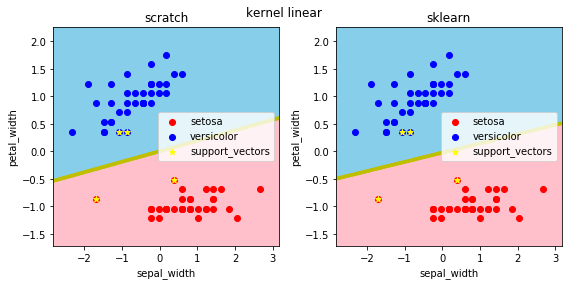

In [24]:
# 決定領域の図
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# setting
n_class=2
scatter_color = ['red', 'blue']
contourf_color = ['pink', 'skyblue']
target_names = y_choice
fig = plt.figure(figsize=(4*n_class, 4))
fig.suptitle('kernel linear')
X = X_train
y = y_train

mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, 0.01), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, 0.01))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

# scratch_pred
mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
# scratch plot
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel(X_choice[0])
ax.set_ylabel(X_choice[1])
ax.set_title('scratch')
ax.contourf(mesh_f0, mesh_f1, mesh_pred, cmap=ListedColormap(contourf_color))
ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
for i, target in enumerate(set(y)):
    ax.scatter(X[y==target][:, 0], X[y==target][:, 1], color=scatter_color[i], label=target_names[i], marker='o')
ax.scatter(X[scratch.index_support_vectors][:, 0], X[scratch.index_support_vectors][:, 1], color='yellow', marker='*', label='support_vectors')
patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
ax.legend(handles=patches)
ax.legend()

# scratch_pred
mesh_pred = svc.predict(mesh).reshape(mesh_f0.shape)
# sklearn plot
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel(X_choice[0])
ax.set_ylabel(X_choice[1])
ax.set_title('sklearn')
ax.contourf(mesh_f0, mesh_f1, mesh_pred, cmap=ListedColormap(contourf_color))
ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
for i, target in enumerate(set(y)):
    ax.scatter(X[y==target][:, 0], X[y==target][:, 1], color=scatter_color[i], label=target_names[i], marker='o')
ax.scatter(X[svc.support_][:, 0], X[svc.support_][:, 1], color='yellow', marker='*', label='support_vectors')
patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
ax.legend(handles=patches)
ax.legend()

fig.tight_layout()
plt.show()

## SVMとはどのような仕組みか

スクラッチ実装に必要な情報は以上ですが、大まかな仕組みの解説を行います。

SVMは決定境界と近くの点の距離（マージン）を最大化する方法です。特徴量が2つであれば以下の図のように線を引くことを考えます。

![image.png](https://t.gyazo.com/teams/diveintocode/a5122026dd2f6c3065ad30bc703e1dbb.png)

決定境界は線形であれば、線形回帰やロジスティック回帰と同様に次の式です。
$$
y(x) = w^{T}x
$$
$x$ : 特徴量ベクトル

$w$ : 重みベクトル

決定境界とある点 $x$ との距離 $r$ は以下の式で求められます。高校数学で学ぶ「点と直線の距離の公式」や「点と平面の距離の公式」を一般化したものです。
$$
r = \frac{y_{i}y(x)}{||w||} = \frac{y_{i}w^{T}x}{||w||}
$$

$||w||$ はベクトル $w$ の大きさで、特徴量が2つならば $||w|| = \sqrt{w_{1}^2+w_{2}^2}$ です。また、学習するi番目のデータのラベルを $y_{i}=-1$または$y_{i}=1$ としています。


訓練データの中で「最も距離 $r$ が短くなる点x（サポートベクター）の距離 $r$ を最大化する $w$ を求める」ことがSVMによる分類だと言い換えられます。


これは非常に複雑な問題です。 $w$ を変化させると、最も距離 $r$ が短くなる点x（サポートベクター）も変化していくからです。計算するためには、問題を扱いやすい形に変形させる必要があります。

### 扱いやすい形にする

まず定数 $M(>0)$ を置くと、先ほどの問題は、

「$\frac{M}{||w||}$ を $y_{i}(w^{T}x_{i})\geq M$ という条件の元で最大化する $w$ や $M$ を求める問題」

と表現できます。条件式は $x_{i}$ に訓練データの全ての点を入れて成り立つ必要があります。まだまだややこしいですが、これをMで割ってしまいます。そうすると、

「$\frac{1}{||w||}$ を $y_{i}(\frac{w^{T}}{M}x_{i})\geq 1$ という条件の元で最大化する $w$ や $M$ を求める問題」

になり、さらに $w^{T} \gets \frac{w^{T}}{M}$ と置き換えてしまいます。

そうすれば、

「 $\frac{1}{||w||}$ を $y_{i}(w^{T}X_{i})\geq 1$ という条件の元で最大化する $w$を求める問題」

まで簡単化できます。 $\frac{1}{||w||}$ を最大化するというのは $||w||$ を最小化することと同じです。これを後々さらに扱いやすくするために $\frac{1}{2}||w||^2$ を最小化すると考えます。よって、

「 $\frac{1}{2}||w||^2$ を $y_{i}(w^{T}x_{i})\geq 1$ という条件の元で最小化する $w$ を求める問題」

とすることができます

### 解きやすい問題にする（双対化）

こういった不等式制約を持つ最適化問題は次のように **ラグランジュの未定乗数法** で置き換えられることが知られています。

なお、このように難しい問題を別の簡単な問題に言い換えることを **双対化する** といいます。

ラグランジュの未定乗数法を用いると以下のラグランジュ関数が得られます。
$$
L(w,\lambda) = \frac{1}{2}||w||^2 - \sum_{i=1}^{N}\lambda_{i}\{y_{i}(w^{T}x_{i})-1\}
$$
$\lambda$ はラグランジュ乗数と呼ばれる数で、0以上の値です。これを $w$について微分し、0に等しいと置くと、次の式が得られます。
$$
w = \sum_{i=1}^{N}\lambda_{i}y_{i}x_{i}
$$
（この微分のために $||w||$ ではなく $\frac{1}{2}||w||^2$ としています）

これをラグランジュ関数に代入して整理すると
$$
\sum_{i=1}^{N}\lambda_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_{i}\lambda_{j}ｙ_{i}ｙ_{j}x_{i}^Tx_{j}
$$
を $\lambda_{i} \geq 0$ かつ $\sum_{n=1}^{N}\lambda_{i}y_{i} = 0$ の条件の元で最大化するときの $\lambda_{i}$ を探す問題に双対化できます。

この形になれば、$\lambda$ を勾配降下法により求めることができます。$w$は出てきませんが、得られる結果は同じです。

### カーネル
最後の式の $x_{i}^{T} x_j$ の部分を $k(x_i, x_j)$ という関数に置き換えます。この関数を **カーネル関数** と呼びます。
$$
\sum_{i=1}^{N}\lambda_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_{i}\lambda_{j}ｙ_{i}ｙ_{j}k(x_i, x_j)
$$
この式が問題1の最急降下法の式の元になります。

カーネル関数は $x_{i}^{T} x_j$ ではない様々な計算に置き換えることができます。この部分を置き換えるだけで、元の特徴量を **高次元空間** に移動させたことと同じ結果が得られ、高い分類性能を得ることができます。これを **カーネルトリック** と呼びます

### 高次元へ移す簡単な例
次の図のように1次元上に2色の点があるとします。これらを直線一本を引くことで分けることは不可能です。
![image.png](https://t.gyazo.com/teams/diveintocode/e75b3c8d2692afa9fba4f76485a883eb.png)
しかし、例えば以下のように変換してみると直線でも分けられそうです。
$x^2=2.5$ あたりに線を引くことになります。
![image.png](https://t.gyazo.com/teams/diveintocode/5f5bacd8aac5831f1936759362b8a184.png)
これは$x^2$を計算し、それを縦軸にプロットしたグラフです。1次元だったデータを $\phi(x)=x^2$ の関数により高次元（2次元）へと移動しました。

こういったことをSVMはカーネルトリックにより行います。

## 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。

「線形カーネルの式」
$$
k(x_i, x_j) = x_{i}^{T} x_j
$$
「多項式カーネルの式」
$$
k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}
$$

$\gamma$, $\theta_0$, $d$ はハイパーパラメータです。

線形カーネルは $\gamma = 1$, $\theta_0 = 0$, $d = 1$の場合の多項式カーネルと等しいと言えます。

In [25]:
def _poly_kernel(a, b, degree=3, gamma='scale', coef0=0.0):
    """
    多項式のカーネル関数を計算する
    Parameters
    ----------
    a : 次の形のndarray, shape (n, m) , もしくは (m, )
    b : 次の形のndarray, shape (m, l) , もしくは　(m, 1)
    特徴量データ
    degree : int
    gamma : {'scale', 'auto'} or float
        if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
        if ‘auto’, uses 1 / n_features.
    coef0 = float
    Returns
    -------
    　　次の形のndarray, shape (n, l)
      線形カーネルの計算結果
    """
    if len(a.shape) == 2:
        n_features = a.shape[1]
    elif len(a.shape) == 1:
        n_features = a.shape[0]
    if gamma == 'scale':
        gamma = 1 / (n_features * np.var(a))
    elif gamma == 'auto':
        gamma = 1 / n_features
    return np.power((gamma * a) @ b.T + coef0, degree)

- 上のスクラッチへ実装
- skleanと比較する

In [26]:
scratch_poly = ScratchSVMClassifier(num_iter=1000, lr=0.01, threshold = 1e-3, verbose=True, random_state=0, kernel='poly', gamma='scale', degree=3)
scratch_poly.fit(X_train, y_train)

iter : 1
index_support_vectors : (array([ 0,  1,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 19, 21, 22, 23,
       25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 55, 56, 59, 60, 61, 62, 63, 66, 68, 69,
       70, 71, 72, 73, 74]),)
n_support_vectors : (56,)
y_sv : [-1 -1  1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1  1  1  1 -1 -1]
iter : 2
index_support_vectors : (array([ 1,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 19, 21, 22, 23, 25,
       27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 42, 44, 46, 48, 49,
       50, 51, 52, 55, 56, 59, 60, 61, 62, 63, 66, 68, 70, 71, 72, 73, 74]),)
n_support_vectors : (51,)
y_sv : [-1  1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1
 -1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1  1  1
  1 -1 -1]
iter : 3
index_support_vectors : (array([ 1,  2,  3,  

iter : 253
index_support_vectors : (array([ 1, 14, 15, 17, 18, 23, 28, 30, 32, 33, 36, 39, 48, 55, 60, 61, 63,
       70, 71, 72, 73]),)
n_support_vectors : (21,)
y_sv : [-1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1]
iter : 254
index_support_vectors : (array([ 1, 14, 15, 17, 18, 23, 28, 30, 32, 33, 36, 39, 48, 55, 60, 61, 63,
       70, 71, 72, 73]),)
n_support_vectors : (21,)
y_sv : [-1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1]
iter : 255
index_support_vectors : (array([ 1, 14, 15, 17, 18, 23, 28, 30, 32, 33, 36, 39, 48, 55, 60, 61, 63,
       70, 71, 72, 73]),)
n_support_vectors : (21,)
y_sv : [-1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1]
iter : 256
index_support_vectors : (array([ 1, 14, 15, 17, 18, 23, 28, 30, 32, 33, 36, 39, 48, 55, 60, 61, 63,
       70, 71, 72, 73]),)
n_support_vectors : (21,)
y_sv : [-1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1]
iter : 257
index_support_vectors : (array([ 1, 14, 15, 17, 1

iter : 436
index_support_vectors : (array([14, 15, 17, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (17,)
y_sv : [ 1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 437
index_support_vectors : (array([14, 15, 17, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (17,)
y_sv : [ 1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 438
index_support_vectors : (array([14, 15, 17, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (17,)
y_sv : [ 1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 439
index_support_vectors : (array([14, 15, 17, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (17,)
y_sv : [ 1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 440
index_support_vectors : (array([14, 15, 17, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (17,)
y_sv : [ 1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]


index_support_vectors : (array([14, 15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (16,)
y_sv : [ 1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 598
index_support_vectors : (array([14, 15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (16,)
y_sv : [ 1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 599
index_support_vectors : (array([14, 15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (16,)
y_sv : [ 1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 600
index_support_vectors : (array([14, 15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (16,)
y_sv : [ 1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 601
index_support_vectors : (array([14, 15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 61, 63, 70, 71, 72]),)
n_support_vectors : (16,)
y_sv : [ 1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1  1]
iter : 602
index_support_vectors : (array([14,

iter : 784
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 63, 70, 71, 72]),)
n_support_vectors : (14,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1]
iter : 785
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 63, 70, 71, 72]),)
n_support_vectors : (14,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1]
iter : 786
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 63, 70, 71, 72]),)
n_support_vectors : (14,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1]
iter : 787
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 48, 55, 63, 70, 71, 72]),)
n_support_vectors : (14,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1]
iter : 788
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1]
iter : 789
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vect

iter : 953
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1]
iter : 954
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1]
iter : 955
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1]
iter : 956
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1]
iter : 957
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1]
iter : 958
index_support_vectors : (array([15, 18, 23, 28, 30, 33, 36, 39, 55, 63, 70, 71, 72]),)
n_support_vectors : (13,)
y_sv : [-1 -1 -1

In [27]:
scratch_poly_pred = scratch_poly.predict(X_test)
scratch_poly_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0])

In [28]:
score_calc(y_test, scratch_poly_pred, label=scratch_poly.max_y)

Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


In [29]:
from sklearn.svm import SVC
svc_poly = SVC(verbose = True, kernel='poly', random_state=0, gamma='scale', degree=3)
svc_poly.fit(X_train, y_train)
svc_poly.support_, svc_poly.support_.shape[0]

[LibSVM]

(array([ 1, 15, 18, 23, 28, 33, 36, 55, 39, 61, 63, 70, 71, 72],
       dtype=int32),
 14)

In [30]:
sklearn_poly_pred = svc_poly.predict(X_test)
sklearn_poly_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0])

In [31]:
score_calc(y_test, sklearn_poly_pred, label=scratch_poly.max_y)

Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


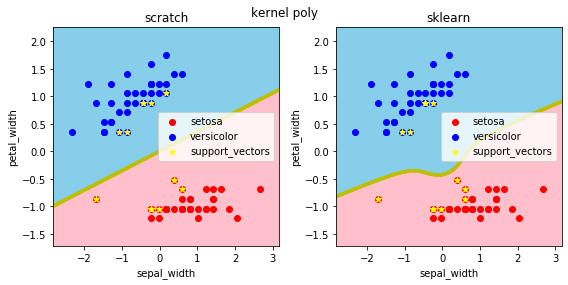

In [32]:
# 決定領域の図
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# setting
n_class=2
scatter_color = ['red', 'blue']
contourf_color = ['pink', 'skyblue']
target_names = y_choice
fig = plt.figure(figsize=(4*n_class, 4))
fig.suptitle('kernel poly')
X = X_train
y = y_train

mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, 0.01), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, 0.01))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

# scratch_pred
mesh_pred = scratch_poly.predict(mesh).reshape(mesh_f0.shape)
# scratch plot
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel(X_choice[0])
ax.set_ylabel(X_choice[1])
ax.set_title('scratch')
ax.contourf(mesh_f0, mesh_f1, mesh_pred, cmap=ListedColormap(contourf_color))
ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
for i, target in enumerate(set(y)):
    ax.scatter(X[y==target][:, 0], X[y==target][:, 1], color=scatter_color[i], label=target_names[i], marker='o')
ax.scatter(X[scratch_poly.index_support_vectors][:, 0], X[scratch_poly.index_support_vectors][:, 1], color='yellow', marker='*', label='support_vectors')
patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
ax.legend(handles=patches)
ax.legend()

# scratch_pred
mesh_pred = svc_poly.predict(mesh).reshape(mesh_f0.shape)
# sklearn plot
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel(X_choice[0])
ax.set_ylabel(X_choice[1])
ax.set_title('sklearn')
ax.contourf(mesh_f0, mesh_f1, mesh_pred, cmap=ListedColormap(contourf_color))
ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
for i, target in enumerate(set(y)):
    ax.scatter(X[y==target][:, 0], X[y==target][:, 1], color=scatter_color[i], label=target_names[i], marker='o')
ax.scatter(X[svc_poly.support_][:, 0], X[svc_poly.support_][:, 1], color='yellow', marker='*', label='support_vectors')
patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
ax.legend(handles=patches)
ax.legend()

fig.tight_layout()
plt.show()

- サポートベクトルの抽出は大まか一致しているが、sklearn では決定領域が歪んでいるが、scratchでは線形になってしまっている。何故？

#### 追加
- ラベル、特徴量の選び方を全てのパターンで試す

In [33]:
# 予測から図示まで関数化
def display_show(X_train, y_train, X_test, y_test, X_choice, y_choice, kernel='linear'):
    scratch = ScratchSVMClassifier(num_iter=1000, lr=0.01, threshold = 1e-3, verbose=False, random_state=0, kernel=kernel)
    scratch.fit(X_train, y_train)
    scratch_pred = scratch.predict(X_test)
    print('scratchの予測　:\n{}'.format(scratch_pred))
    print('scratchの評価　:')
    score_calc(y_test, scratch_pred, label=scratch.max_y)
    print()
    from sklearn.svm import SVC
    svc = SVC(verbose = False, kernel=kernel, random_state=0)
    svc.fit(X_train, y_train)
    sklearn_pred = svc.predict(X_test)
    print('sklearnの予測　:\n{}'.format(sklearn_pred))
    print('sklearnの評価　:')
    score_calc(y_test, sklearn_pred, label=scratch.max_y)
    
    # 決定領域の図
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as mpatches
    # setting
    n_class=2
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    target_names = y_choice
    fig = plt.figure(figsize=(4*n_class, 4))
    fig.suptitle('kernel '+kernel)
    X = X_train
    y = y_train

    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, 0.01), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, 0.01))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # scratch_pred
    mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
    # scratch plot
    ax = fig.add_subplot(1, 2, 1)
    ax.set_xlabel(X_choice[0])
    ax.set_ylabel(X_choice[1])
    ax.set_title('scratch')
    ax.contourf(mesh_f0, mesh_f1, mesh_pred, cmap=ListedColormap(contourf_color))
    ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        ax.scatter(X[y==target][:, 0], X[y==target][:, 1], color=scatter_color[i], label=target_names[i], marker='o')
    ax.scatter(X[scratch.index_support_vectors][:, 0], X[scratch.index_support_vectors][:, 1], color='yellow', marker='*', label='support_vectors')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    ax.legend(handles=patches)
    ax.legend()

    # scratch_pred
    mesh_pred = svc.predict(mesh).reshape(mesh_f0.shape)
    # sklearn plot
    ax = fig.add_subplot(1, 2, 2)
    ax.set_xlabel(X_choice[0])
    ax.set_ylabel(X_choice[1])
    ax.set_title('sklearn')
    ax.contourf(mesh_f0, mesh_f1, mesh_pred, cmap=ListedColormap(contourf_color))
    ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        ax.scatter(X[y==target][:, 0], X[y==target][:, 1], color=scatter_color[i], label=target_names[i], marker='o')
    ax.scatter(X[svc.support_][:, 0], X[svc.support_][:, 1], color='yellow', marker='*', label='support_vectors')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    ax.legend(handles=patches)
    ax.legend()

    fig.tight_layout()
    plt.show()    

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


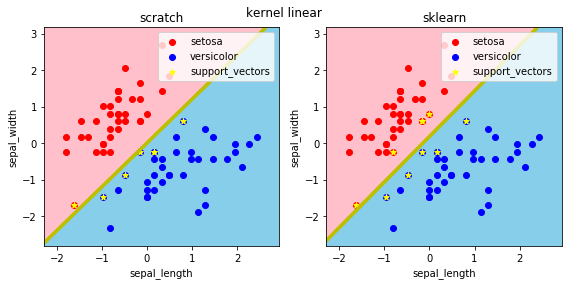

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


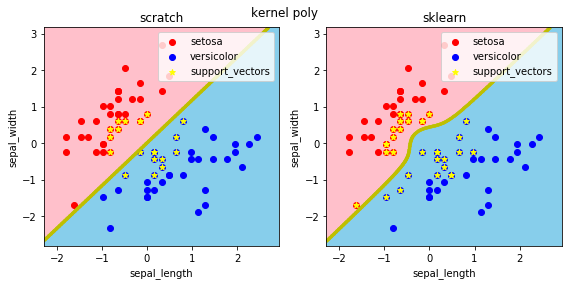

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


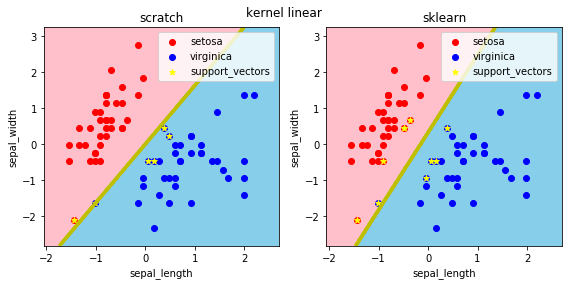

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


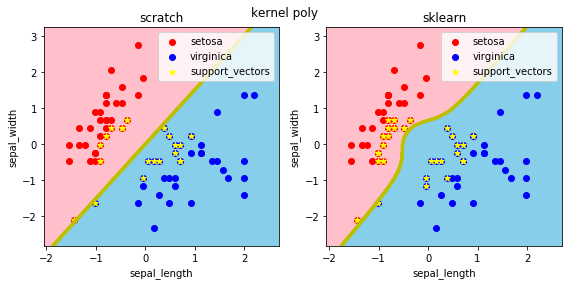

scratchの予測　:
[2 2 2 2 2 2 1 2 2 2 2 1 2 1 1 1 2 2 1 2 1 2 1 1 1]
scratchの評価　:
Accuracy = 0.72, Precision = 0.6666666666666666, Recall = 0.8333333333333334, F値 = 0.7407407407407408

sklearnの予測　:
[2 2 2 2 2 2 1 1 2 2 2 1 2 1 1 1 1 2 1 2 1 2 1 1 1]
sklearnの評価　:
Accuracy = 0.72, Precision = 0.6923076923076923, Recall = 0.75, F値 = 0.7199999999999999


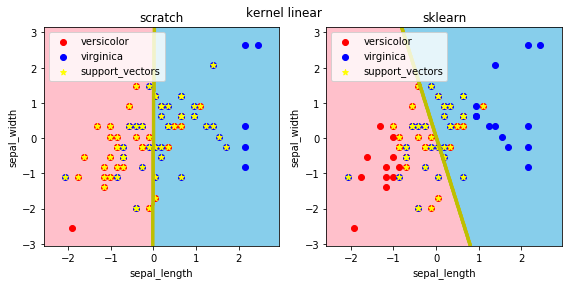

scratchの予測　:
[2 2 2 2 2 2 1 1 2 2 2 1 2 1 1 1 1 2 1 2 1 2 1 1 1]
scratchの評価　:
Accuracy = 0.72, Precision = 0.6923076923076923, Recall = 0.75, F値 = 0.7199999999999999

sklearnの予測　:
[2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 1 2 2 2 2 1 2 1 1 1]
sklearnの評価　:
Accuracy = 0.64, Precision = 0.5882352941176471, Recall = 0.8333333333333334, F値 = 0.6896551724137931


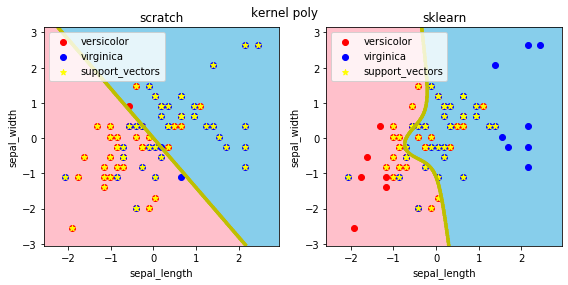

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


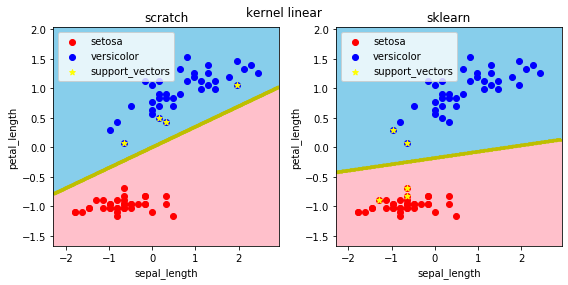

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


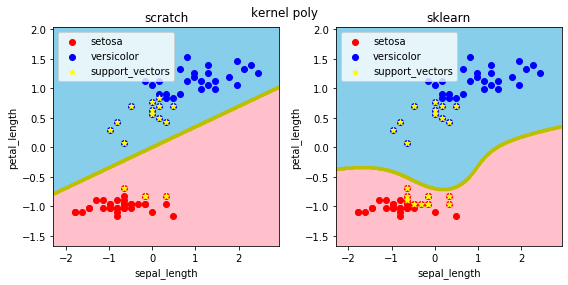

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


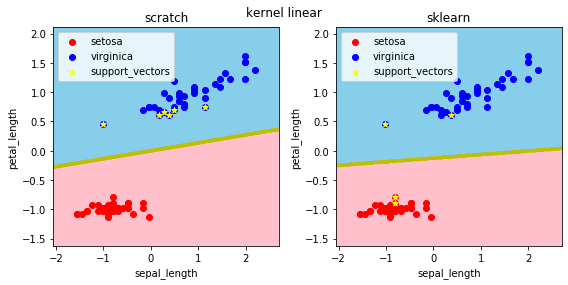

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


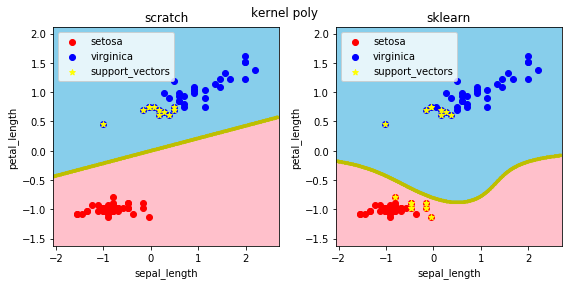

scratchの予測　:
[1 2 1 2 2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 0.92, Precision = 0.9166666666666666, Recall = 0.9166666666666666, F値 = 0.9166666666666666

sklearnの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.92, Precision = 0.8571428571428571, Recall = 1.0, F値 = 0.923076923076923


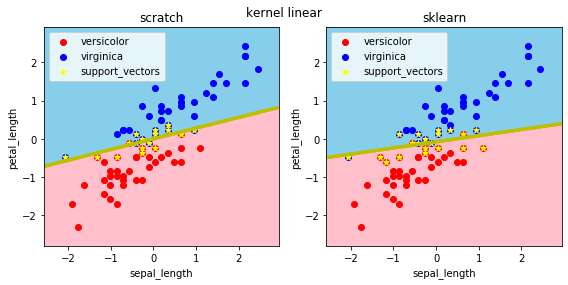

scratchの予測　:
[1 2 1 2 2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 0.92, Precision = 0.9166666666666666, Recall = 0.9166666666666666, F値 = 0.9166666666666666

sklearnの予測　:
[2 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.76, Precision = 0.6666666666666666, Recall = 1.0, F値 = 0.8


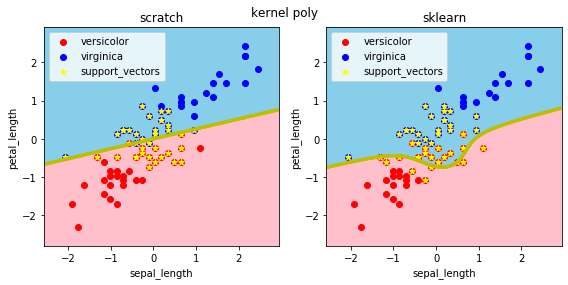

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


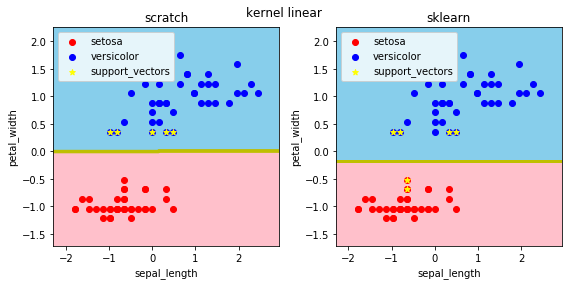

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


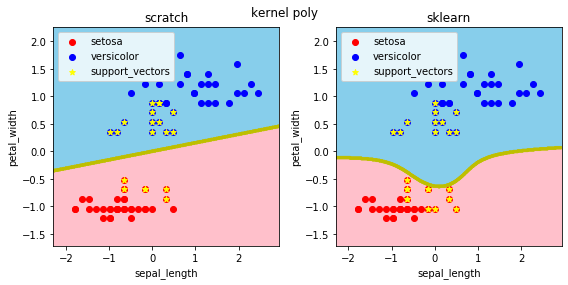

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


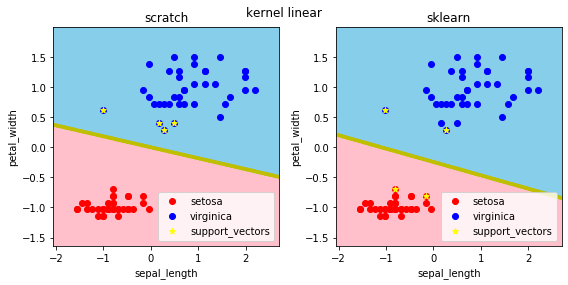

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


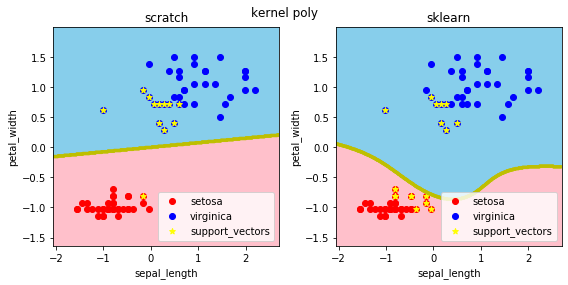

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


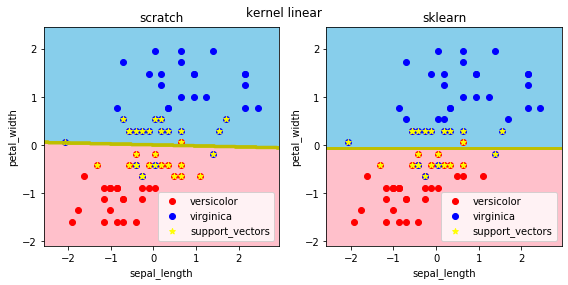

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.92, Precision = 0.8571428571428571, Recall = 1.0, F値 = 0.923076923076923


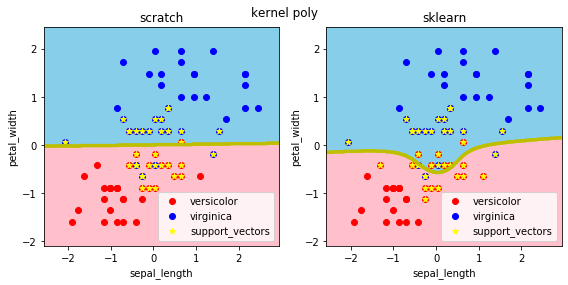

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


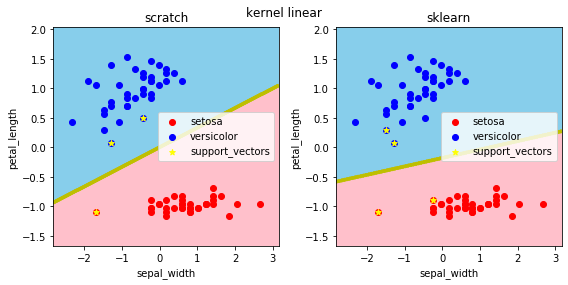

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


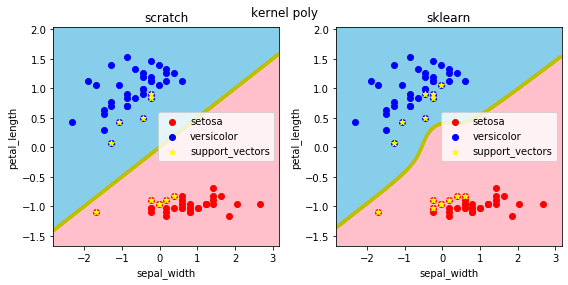

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


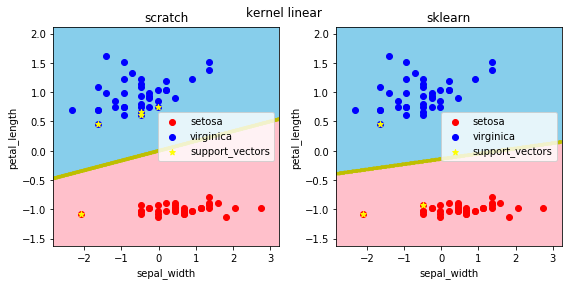

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


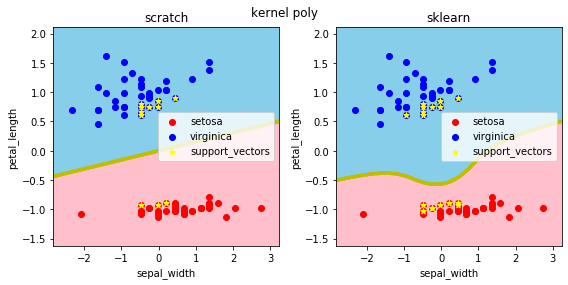

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 0.92, Precision = 0.8571428571428571, Recall = 1.0, F値 = 0.923076923076923

sklearnの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.92, Precision = 0.8571428571428571, Recall = 1.0, F値 = 0.923076923076923


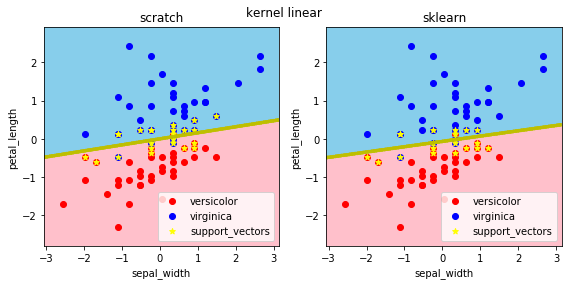

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 0.92, Precision = 0.8571428571428571, Recall = 1.0, F値 = 0.923076923076923

sklearnの予測　:
[1 2 1 2 2 2 1 1 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 1 1]
sklearnの評価　:
Accuracy = 0.84, Precision = 0.8333333333333334, Recall = 0.8333333333333334, F値 = 0.8333333333333334


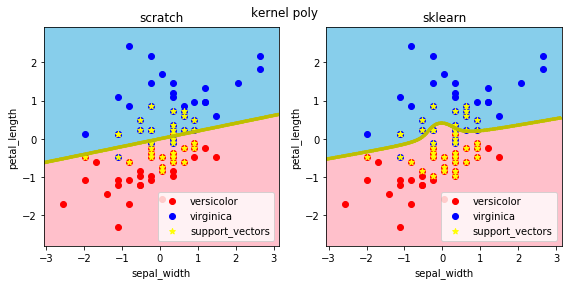

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


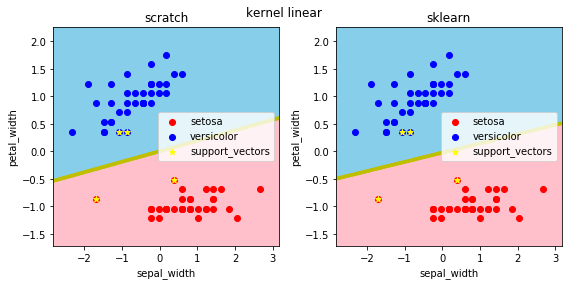

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


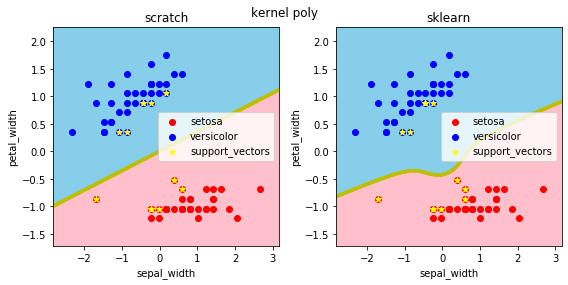

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


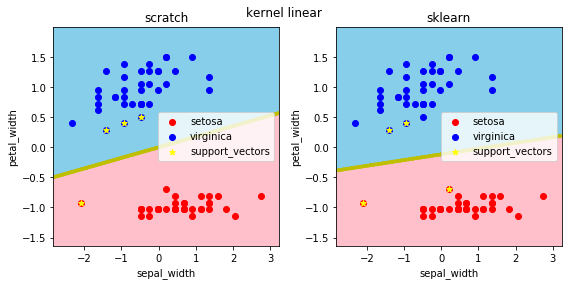

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


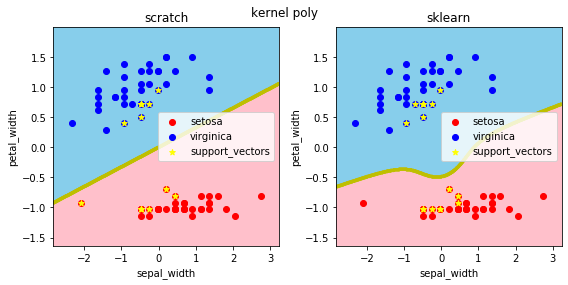

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 2 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.96, Precision = 0.9230769230769231, Recall = 1.0, F値 = 0.9600000000000001


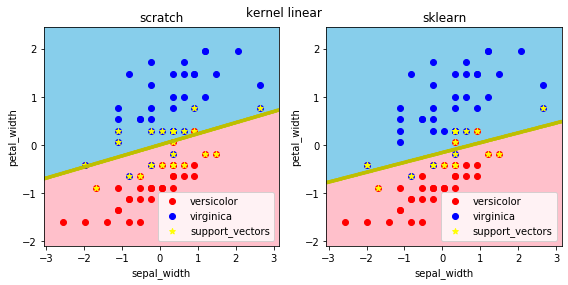

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[1 2 1 2 1 2 1 2 2 2 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.92, Precision = 1.0, Recall = 0.8333333333333334, F値 = 0.9090909090909091


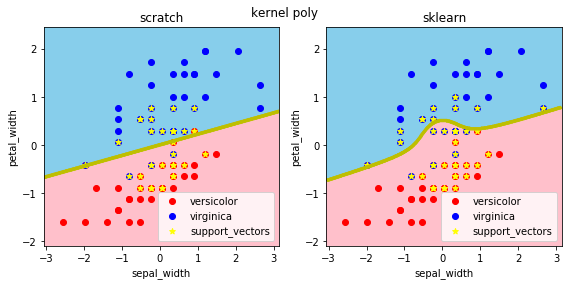

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


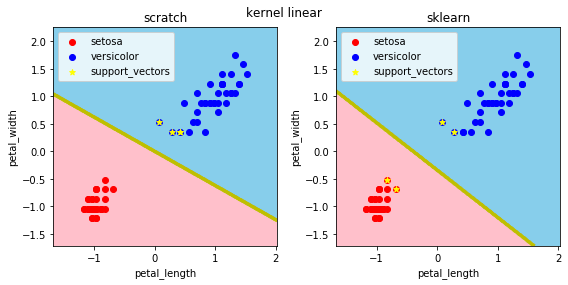

scratchの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


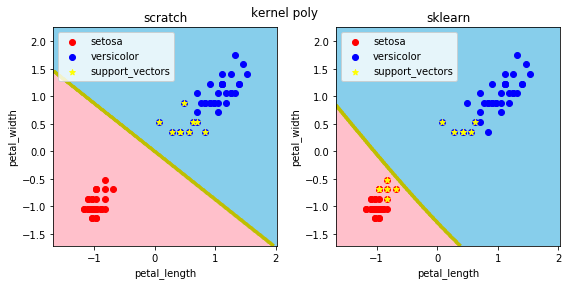

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


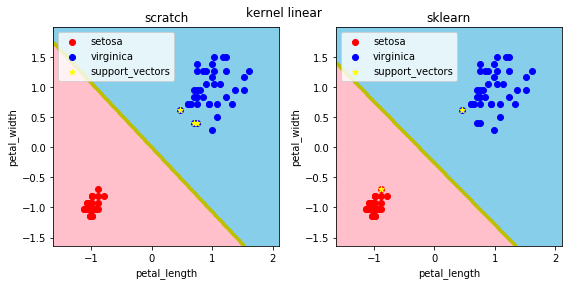

scratchの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
scratchの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0

sklearnの予測　:
[0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0]
sklearnの評価　:
Accuracy = 1.0, Precision = 1.0, Recall = 1.0, F値 = 1.0


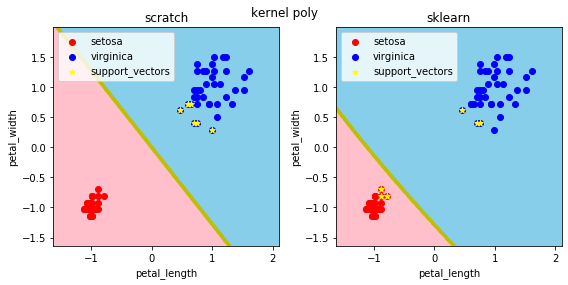

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 2 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 0.96, Precision = 0.9230769230769231, Recall = 1.0, F値 = 0.9600000000000001

sklearnの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 2 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.96, Precision = 0.9230769230769231, Recall = 1.0, F値 = 0.9600000000000001


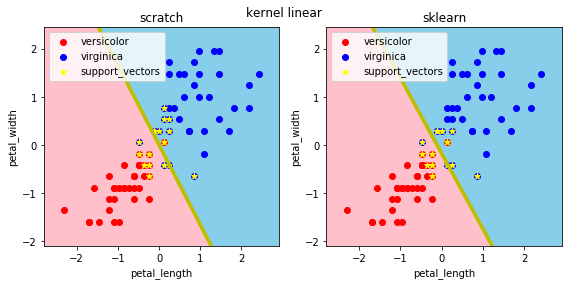

scratchの予測　:
[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 2 1 1 2 1 2 1]
scratchの評価　:
Accuracy = 0.96, Precision = 0.9230769230769231, Recall = 1.0, F値 = 0.9600000000000001

sklearnの予測　:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]
sklearnの評価　:
Accuracy = 0.76, Precision = 0.6666666666666666, Recall = 1.0, F値 = 0.8


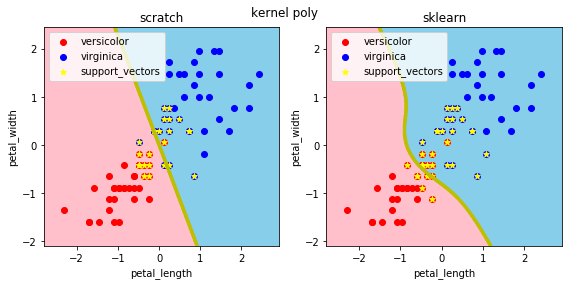

In [34]:
# ３種類のラベル、４つの特徴量の全てのパターンを図示
from itertools import combinations
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
label_names = ['setosa', 'versicolor', 'virginica']
for x  in combinations(feature_names, 2):
    X_choice = list(x)
    for y in combinations(label_names, 2):
        y_choice = list(y)
        df_choice = df[df['Species_name'].isin(y_choice)][X_choice + ['Species', 'Species_name']]
        X = df_choice.iloc[:, 0:2].values
        y = df_choice.iloc[:, 2].values
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        for kernel in ['linear', 'poly']:
            display_show(X_train, y_train, X_test, y_test, X_choice, y_choice, kernel=kernel)

### 考察
- kernel linear
    - スクラッチでは、サポートベクトルがどちらかのラベルに偏る傾向がある
- kernel poly
    - サポートベクトルの抽出は凡そsklearnと一致しているようだが、境界線の歪みが反映できていない